# Compare consensus predictions across orgnaisms
When testing the framework on a new organism, it is important to go through the computational validation to assess the quality of the predicted motif. This notebook:
1. walks through the computational validation process for *E. coli* and *B. subtilis* and 
2. provides a template for comparing the results from a new organism to these model organisms. 

*E. coli* and *B. subtilis* were tested at varying thresholds of n (the top n% of genes used to derived a consensus motif). The template for comparing a new organism is demonstrated with *T. maritima*.

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../') # use modules in main directory

import genbank_utils as gu
import consensus_viz_utils as cu

## 1) Computational validation of E. coli and B. subtilis
### Load data for each org
The computational pipeline was previously run for each of these organism at varying thresholds of n. The final `_SELECTION.fa` file is provided for each n% threshold. The run commands to generate the `_SELECTION.fa` files are listed below. (See Github [readme](https://github.com/erinhwilson/promoter-id-from-rnaseq) for more details)

#### M. buryatense
`for N = [1,2,3,4,5,6,10,20]:`

`python get_top_gene_set.py data/extract_TPM_counts.tsv locus_tag [N] 120 data/sample2condition.txt data/5GB1c_sequence.gb mbur_out -c config/conditions_to_include.txt -s config/samples_to_include.txt`

`python extract_upstream_regions.py mbur_out/loci_in_top_[N]perc.txt data/5GB1c_sequence.gb mbur_out`

`python predict_promoter_signal.py mbur_out/loci_in_top_[N]perc_upstream_regions_w300_min20_trunc.fa config/bioprospector_config.txt mbur_out`

#### E. coli
`for N = 1 thru 10:`

`python get_top_gene_set.py data/ecoli_log_TPM_counts.txt locus_tag [N] 83 data/ecoli_sample2condition.txt data/ecoli_NC_000913.3.gb ecoli_out -s config/ecoli_samples_to_include.txt -c config/ecoli_conditions_to_include.txt`

`python extract_upstream_regions.py ecoli_out/loci_in_top_[N]perc.txt data/ecoli_NC_000913.3.gb ecoli_out`

`python predict_promoter_signal.py ecoli_out/loci_in_top_[N]perc_upstream_regions_w300_min20_trunc.fa config/bioprospector_config.txt ecoli_out`

#### B. subtilis
`for N = 3 thru 10:`

`python get_top_gene_set.py data/bsubtilis_nicolas.tsv locus_tag [N] 80 data/bsub_sample2condition.txt data/bsubtilis_AL009126.gbff bsub_out -s config/bsub_samples_to_include.txt -c config/bsub_conditions_to_include.txt`

`python extract_upstream_regions.py bsub_out/loci_in_top_[N]perc.txt data/bsubtilis_AL009126.gbff bsub_out -r `

`python predict_promoter_signal.py bsub_out/loci_in_top_[N]perc_upstream_regions_w300_minus15_min20_trunc.fa config/bioprospector_config.txt bsub_out`

In [2]:
# --- M. buryatense ---
mb_f_dict = {
    1:'../mbur_out/loci_in_top_1perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952145_SELECTION.fa',
    2:'../mbur_out/loci_in_top_2perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1599038857_SELECTION.fa',
    3:'../mbur_out/loci_in_top_3perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952202_SELECTION.fa',
    4:'../mbur_out/loci_in_top_4perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1599039044_SELECTION.fa',
    5:'../mbur_out/loci_in_top_5perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952321_SELECTION.fa',
    6:'../mbur_out/loci_in_top_6perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1599039246_SELECTION.fa',
    10:'../mbur_out/loci_in_top_10perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952515_SELECTION.fa',
    20:'../mbur_out/loci_in_top_20perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598953063_SELECTION.fa',
}
mb_gbFile = "../data/5GB1c_sequence.gb"

# --- E. coli ---
ec_f_dict = {
    1:'../ecoli_out/loci_in_top_1perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616202668_SELECTION.fa',
    2:'../ecoli_out/loci_in_top_2perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616202614_SELECTION.fa',
    3:'../ecoli_out/loci_in_top_3perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1615799844_SELECTION.fa',
    4:'../ecoli_out/loci_in_top_4perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1615799724_SELECTION.fa',
    5:'../ecoli_out/loci_in_top_5perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1615799564_SELECTION.fa',
    6:'../ecoli_out/loci_in_top_6perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1615799334_SELECTION.fa',
    7:'../ecoli_out/loci_in_top_7perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1615799001_SELECTION.fa',
    8:'../ecoli_out/loci_in_top_8perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1615798640_SELECTION.fa',
    9:'../ecoli_out/loci_in_top_9perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1615798208_SELECTION.fa',
    10:'../ecoli_out/loci_in_top_10perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1615797619_SELECTION.fa'
    
}
ec_gbFile = '../data/ecoli_NC_000913.3.gb'

# --- B. subtilis ---
bs_f_dict = {
    3:'../bsub_out/loci_in_top_3perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1617146461_SELECTION.fa',
    4:'../bsub_out/loci_in_top_4perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1617146394_SELECTION.fa',
    5:'../bsub_out/loci_in_top_5perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616122559_SELECTION.fa',
    6:'../bsub_out/loci_in_top_6perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616122046_SELECTION.fa',
    7:'../bsub_out/loci_in_top_7perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616121902_SELECTION.fa',
    8:'../bsub_out/loci_in_top_8perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616121073_SELECTION.fa',
    9:'../bsub_out/loci_in_top_9perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616121645_SELECTION.fa',
    10:'../bsub_out/loci_in_top_10perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616120092_SELECTION.fa',    
}
bs_gbFile = "../data/bsubtilis_AL009126.gbff"

### If you've already run this notebook and saved an output, just reload
The reload is much shorter than running the genome match finding code

reloading match file...
reloading baseline info...
Genome length: 4998879 bps
ATGAGTGCAC
GTGCACTCAT
Building 1% category dfs


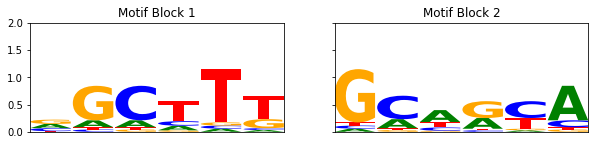

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 2% category dfs


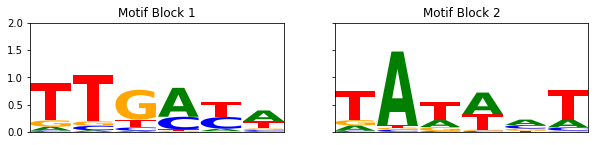

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 3% category dfs


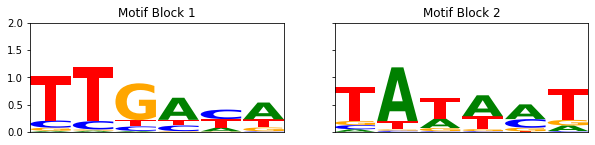

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 4% category dfs


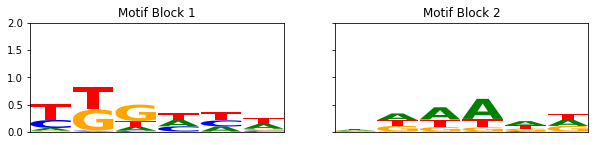

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 5% category dfs


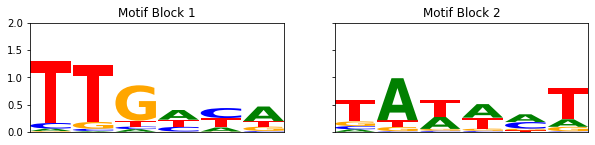

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 6% category dfs


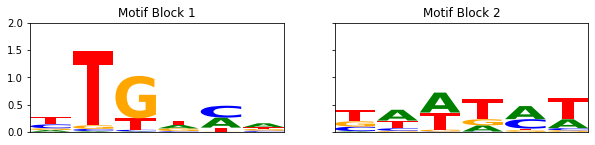

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 10% category dfs


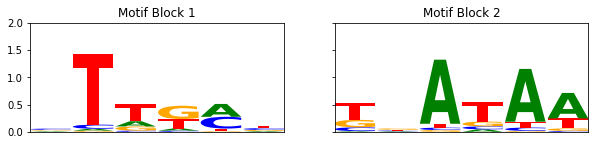

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 20% category dfs


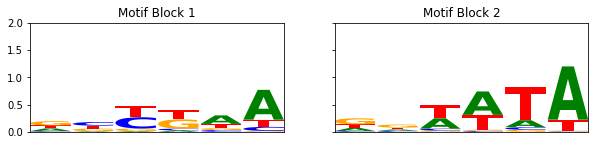

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Concatting final dfs


In [3]:
mb_match_file = "../mbur_out/mbur1-20_all_motif_match_df.tsv"
mb_motif_dict, \
mb_all_motif_match_cat_df, \
mb_all_top_motif_match_cat_df = cu.reload_match_df_info(mb_match_file,mb_f_dict,mb_gbFile)

reloading match file...
reloading baseline info...
Genome length: 4641652 bps
AGCTTTTCAT
ATGAAAAGCT
Building 1% category dfs


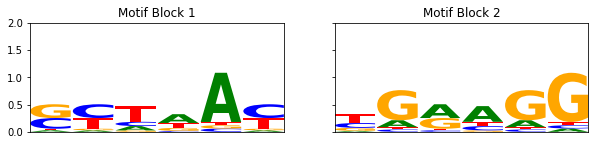

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Building 2% category dfs


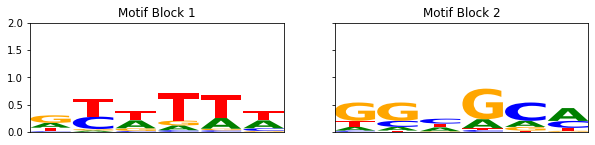

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Building 3% category dfs


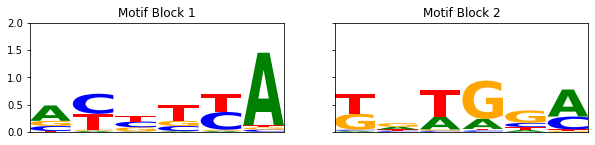

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Building 4% category dfs


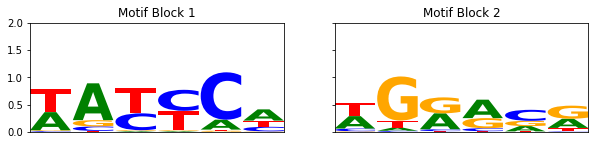

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Building 5% category dfs


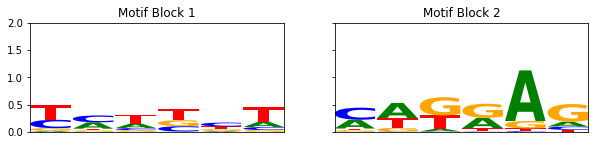

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Building 6% category dfs


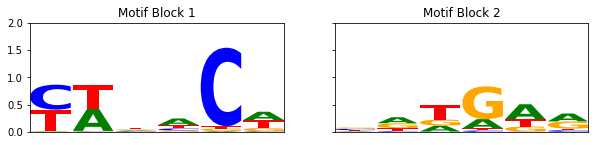

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Building 7% category dfs


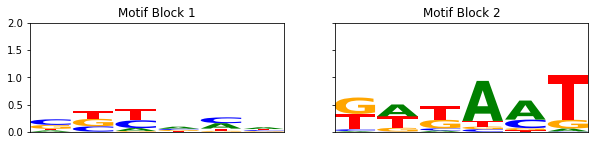

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Building 8% category dfs


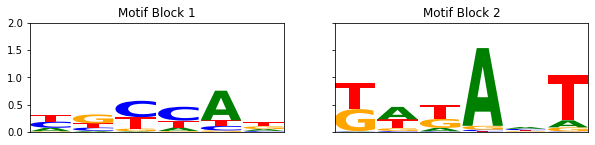

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Building 9% category dfs


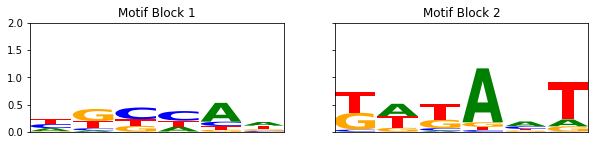

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Building 10% category dfs


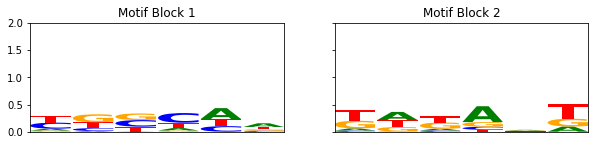

Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Concatting final dfs


In [4]:
ec_match_file = "../ecoli_out/ecoli1-10_all_motif_match_df.tsv"
ec_motif_dict, \
ec_all_motif_match_cat_df, \
ec_all_top_motif_match_cat_df = cu.reload_match_df_info(ec_match_file,ec_f_dict,ec_gbFile, threshold=10)

reloading match file...
reloading baseline info...
Genome length: 4215606 bps
ATCTTTTTCG
CGAAAAAGAT
Building 3% category dfs


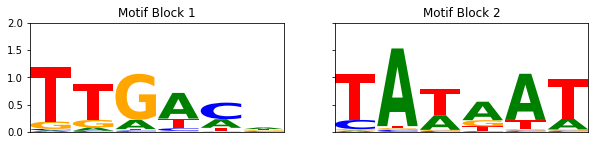

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 4% category dfs


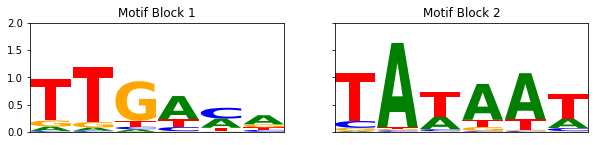

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 5% category dfs


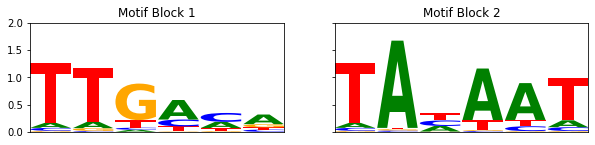

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 6% category dfs


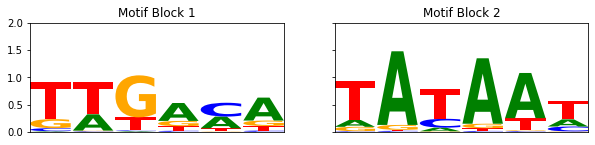

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 7% category dfs


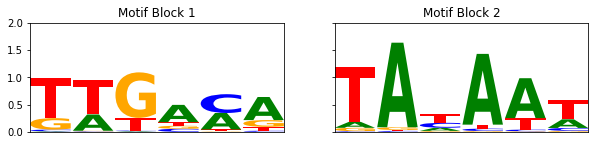

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 8% category dfs


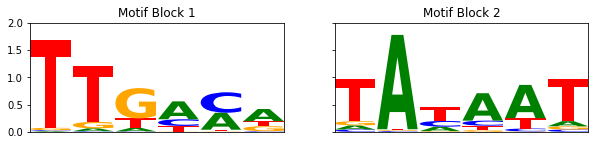

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 9% category dfs


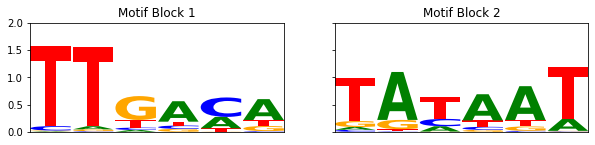

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Building 10% category dfs


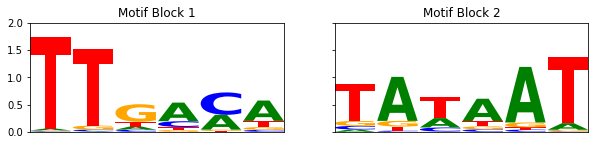

Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Concatting final dfs


In [5]:
bs_match_file = "../bsub_out/bsub3-10_all_motif_match_df.tsv"
bs_motif_dict, \
bs_all_motif_match_cat_df, \
bs_all_top_motif_match_cat_df = cu.reload_match_df_info(bs_match_file,bs_f_dict,bs_gbFile)

### If not able to load, run code to find motif matches and collect for all values of n% requested
** Don't run this section of cells if you've already run the reload section above! ** If this is your first time through, uncomment and run these cells.

Genome length: 4998879 bps
ATGAGTGCAC
GTGCACTCAT

Top 1% consensus


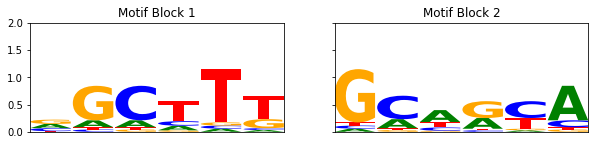

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 2% consensus


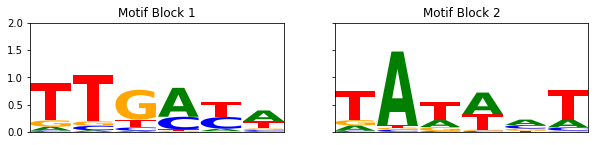

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 3% consensus


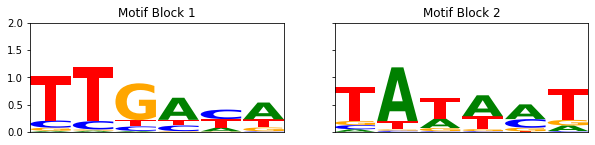

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 4% consensus


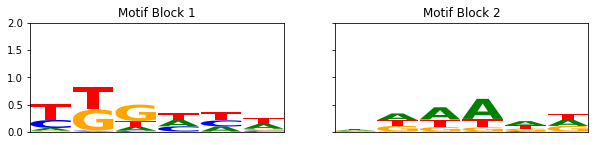

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 5% consensus


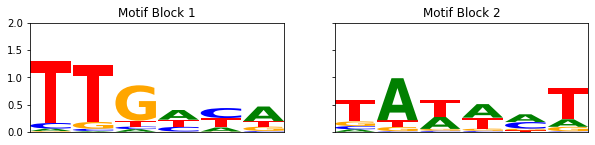

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 6% consensus


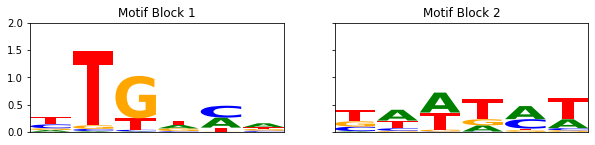

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 10% consensus


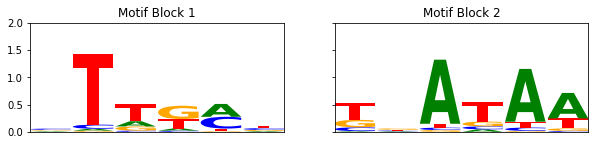

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 20% consensus


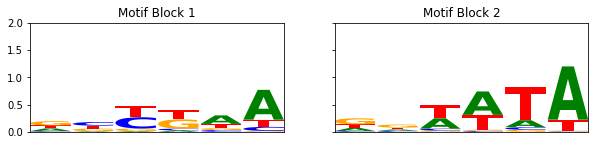

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Concatting final dfs


In [3]:
# mb_motif_dict, \
# mb_all_hex_df, \
# mb_all_motif_match_df, \
# mb_all_motif_match_cat_df, \
# mb_all_top_motif_match_cat_df = cu.compare_consensus_motifs(mb_f_dict,mb_gbFile,threshold=12)

Genome length: 4641652 bps
AGCTTTTCAT
ATGAAAAGCT

Top 1% consensus


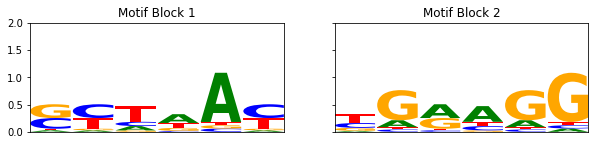

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts

Top 2% consensus


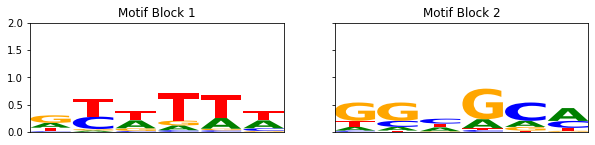

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts

Top 3% consensus


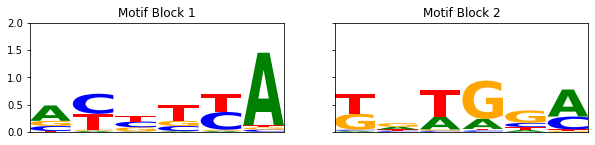

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts

Top 4% consensus


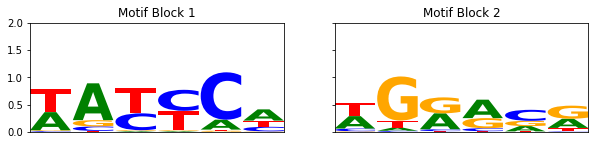

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts

Top 5% consensus


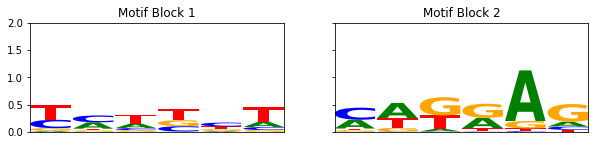

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts

Top 6% consensus


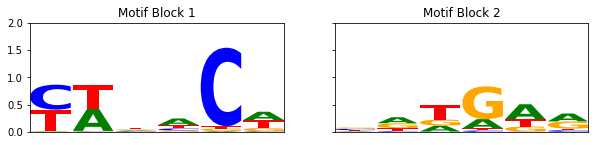

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts

Top 7% consensus


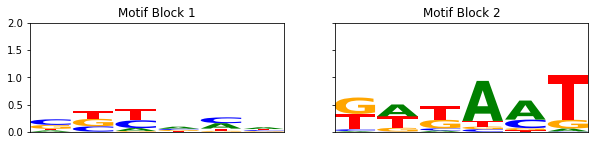

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts

Top 8% consensus


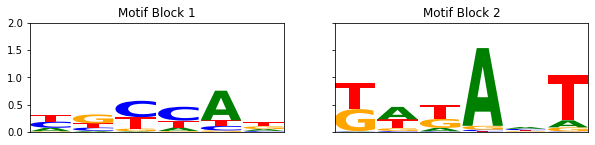

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts

Top 9% consensus


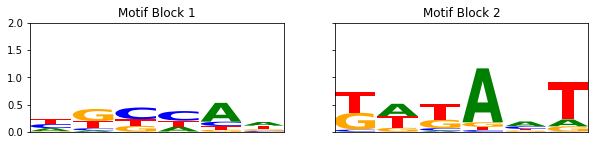

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts

Top 10% consensus


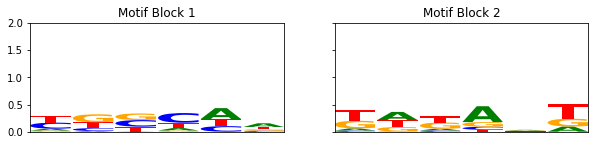

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=10)
Normalizing pssm match counts
Concatting final dfs


In [4]:
# ec_motif_dict, \
# ec_all_hex_df, \
# ec_all_motif_match_df, \
# ec_all_motif_match_cat_df, \
# ec_all_top_motif_match_cat_df = cu.compare_consensus_motifs(ec_f_dict,ec_gbFile,threshold=10) #threshold=10

Genome length: 4215606 bps
ATCTTTTTCG
CGAAAAAGAT

Top 3% consensus


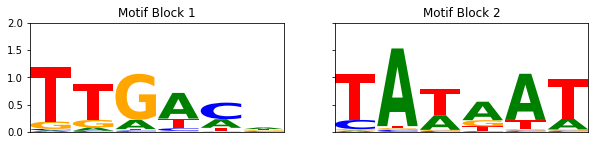

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 4% consensus


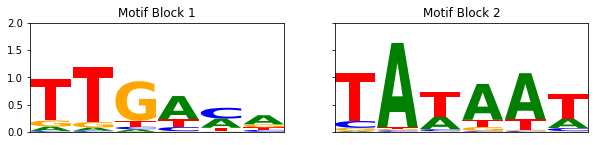

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 5% consensus


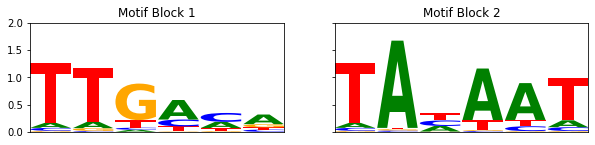

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 6% consensus


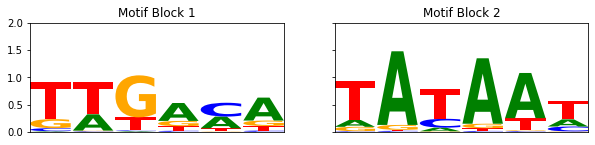

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 7% consensus


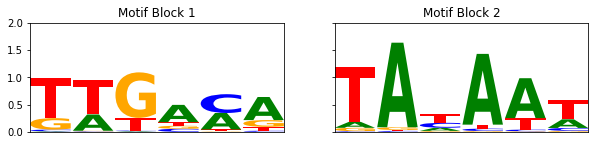

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 8% consensus


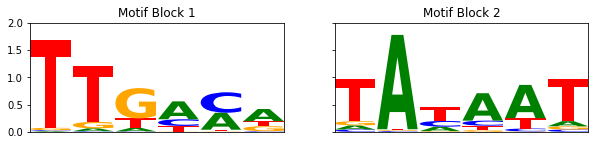

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 9% consensus


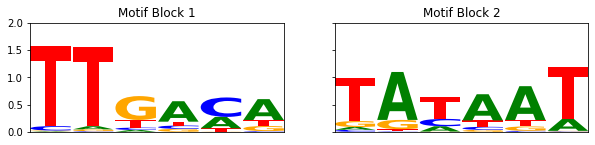

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 10% consensus


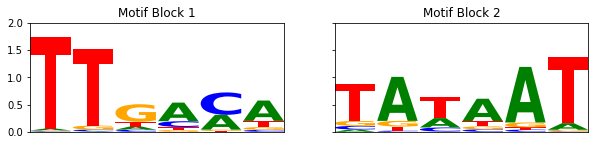

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Concatting final dfs


In [5]:
# bs_motif_dict, \
# bs_all_hex_df, \
# bs_all_motif_match_df, \
# bs_all_motif_match_cat_df, \
# bs_all_top_motif_match_cat_df = cu.compare_consensus_motifs(bs_f_dict,bs_gbFile,threshold=12)

In [7]:
# write out if you haven't before (saves time later)

# mb_all_motif_match_df.to_csv("../mbur_out/mbur1-20_all_motif_match_df.tsv",index=False,sep='\t')
# ec_all_motif_match_df.to_csv("../ecoli_out/ecoli1-10_all_motif_match_df.tsv",index=False,sep='\t')
# bs_all_motif_match_df.to_csv("../bsub_out/bsub3-10_all_motif_match_df.tsv",index=False,sep='\t')


## Visualize genome category enrichment of consensus matches
Same as Figure S3, but now for M. buryatense, E. coli and B. subtilis results

In [6]:
# smaller subset of n% groups used in supp figure visualizations
n_subset = [3,5,8,9,10] 

### M. buryatense

Motif enrichment for all matches


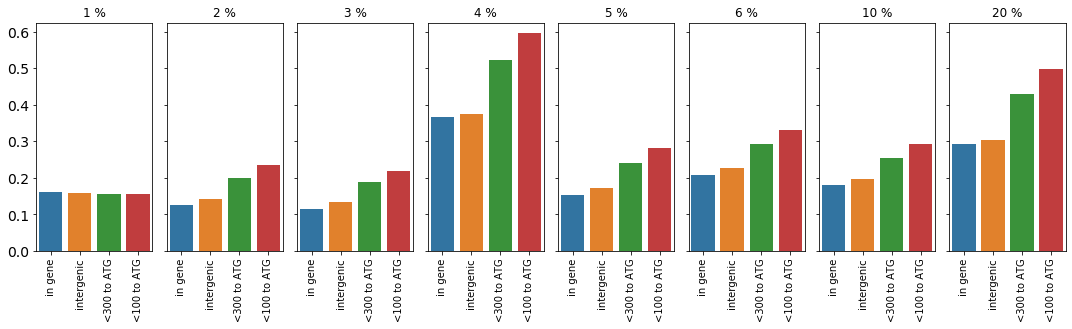

In [7]:
# all pssm matches
print("Motif enrichment for all matches")
cu.compare_genome_cat_enrichment(mb_all_motif_match_cat_df)

Motif enrichment for strong matches > 12.0


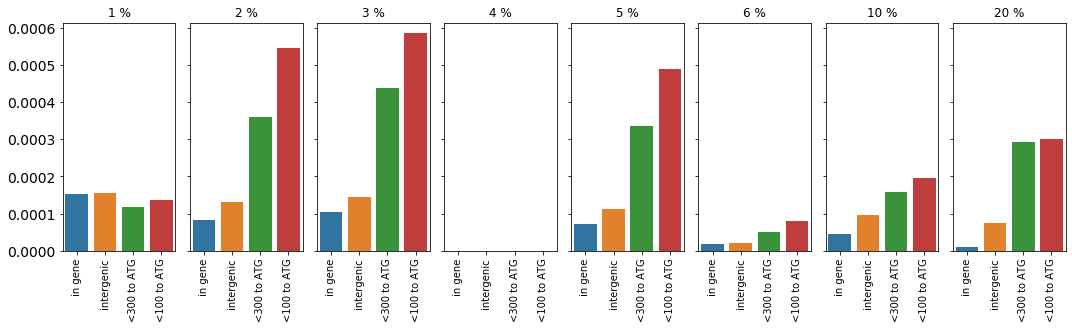

In [8]:
# high scoring pssm above 12
print("Motif enrichment for strong matches > 12.0")
cu.compare_genome_cat_enrichment(mb_all_top_motif_match_cat_df)

### E. coli

Motif enrichment for all matches


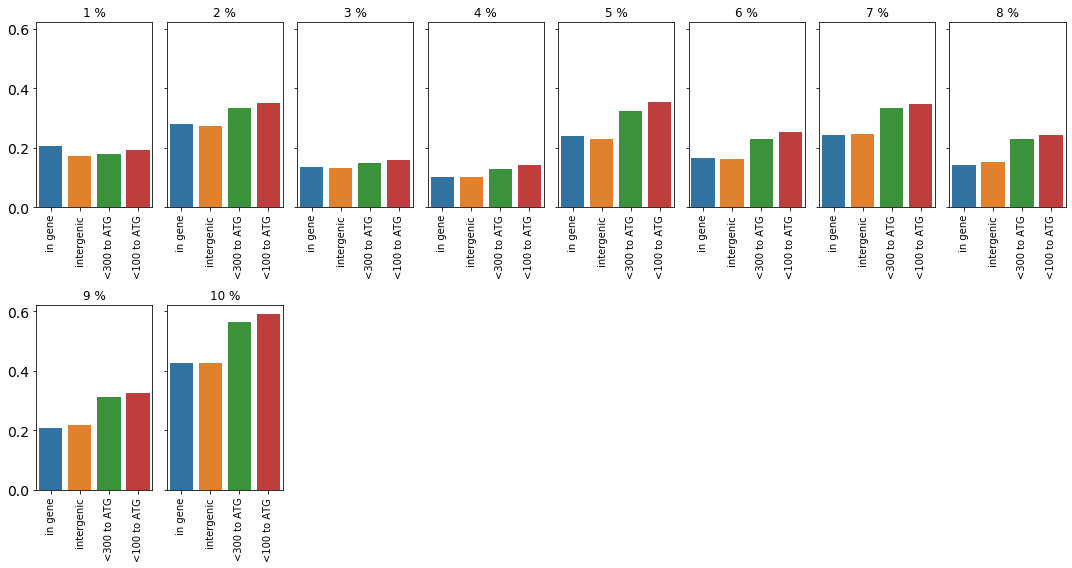

In [9]:
# all pssm matches
print("Motif enrichment for all matches")
cu.compare_genome_cat_enrichment(ec_all_motif_match_cat_df)

Motif enrichment for strong matches > 10.0


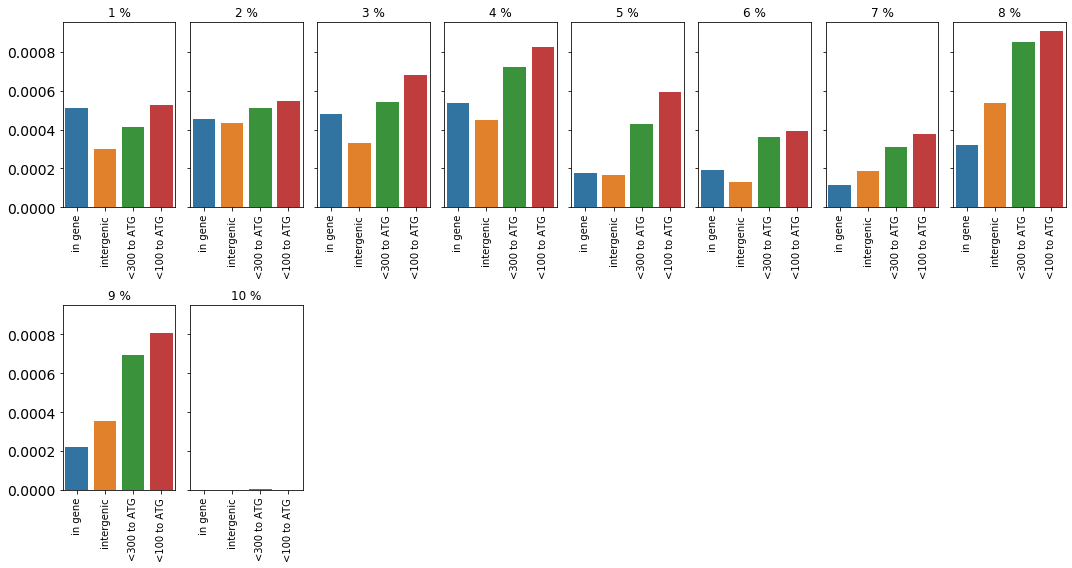

In [10]:
print("Motif enrichment for strong matches > 10.0")
# high scoring pssm above 10
cu.compare_genome_cat_enrichment(ec_all_top_motif_match_cat_df)

Subset of n% groups used in Fig S4
Motif enrichment for all matches
Motif enrichment for strong matches > 10.0


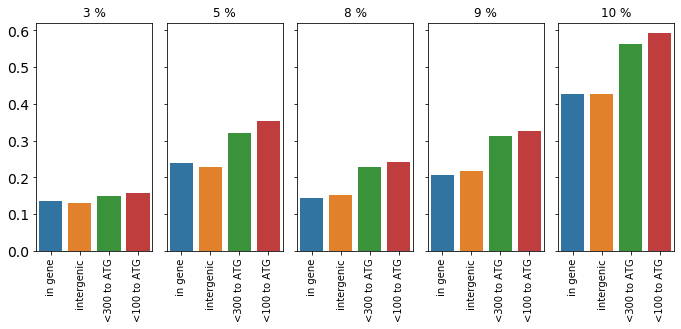

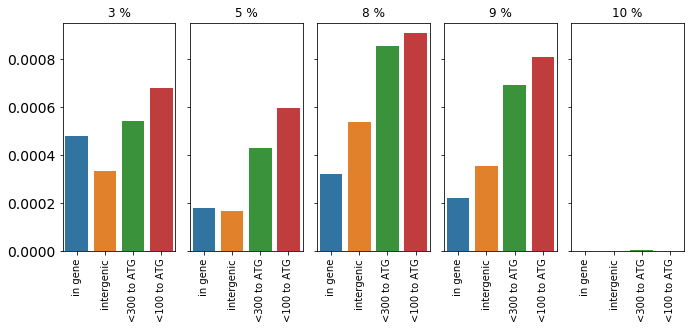

In [11]:
print("Subset of n% groups used in Fig S4")
print("Motif enrichment for all matches")
cu.compare_genome_cat_enrichment(ec_all_motif_match_cat_df[ec_all_motif_match_cat_df['nperc'].isin(n_subset)])
print("Motif enrichment for strong matches > 10.0")
cu.compare_genome_cat_enrichment(ec_all_top_motif_match_cat_df[ec_all_top_motif_match_cat_df['nperc'].isin(n_subset)])

### B. subtilis

Motif enrichment for all matches


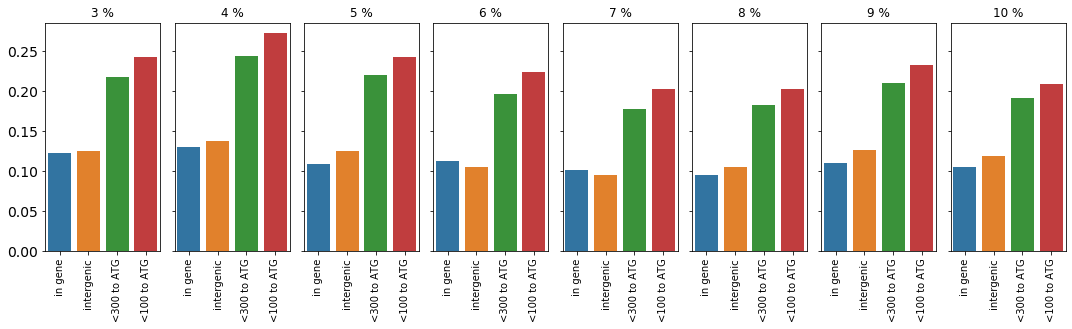

In [12]:
# all pssm matches
print("Motif enrichment for all matches")
cu.compare_genome_cat_enrichment(bs_all_motif_match_cat_df)

Motif enrichment for strong matches > 12.0


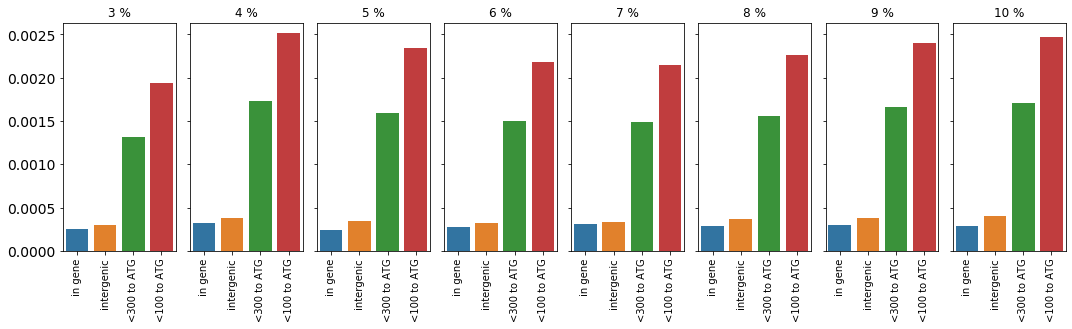

In [13]:
# high scoring pssm above 12
print("Motif enrichment for strong matches > 12.0")
cu.compare_genome_cat_enrichment(bs_all_top_motif_match_cat_df)

Subset of n% groups used in Fig S4
Motif enrichment for all matches
Motif enrichment for strong matches > 12.0


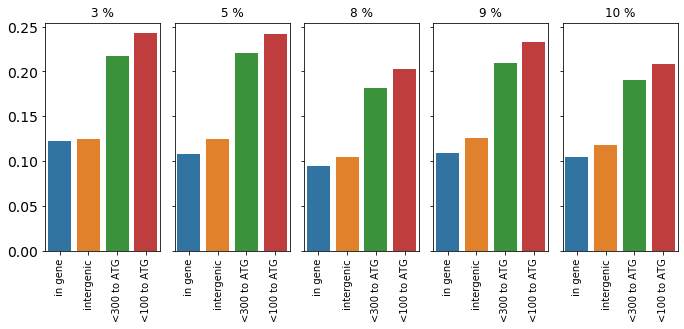

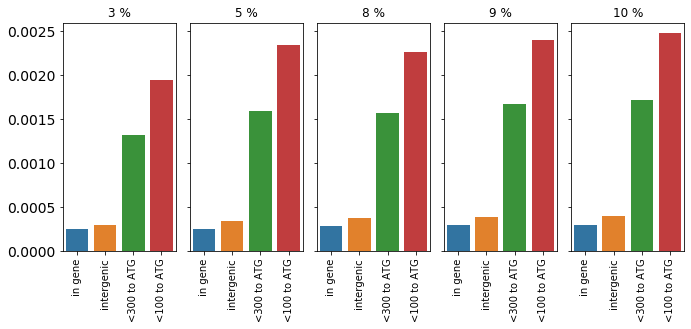

In [14]:
print("Subset of n% groups used in Fig S4")
print("Motif enrichment for all matches")
cu.compare_genome_cat_enrichment(bs_all_motif_match_cat_df[bs_all_motif_match_cat_df['nperc'].isin(n_subset)])
print("Motif enrichment for strong matches > 12.0")
cu.compare_genome_cat_enrichment(bs_all_top_motif_match_cat_df[bs_all_top_motif_match_cat_df['nperc'].isin(n_subset)])

## Visualize promoter enrichment vs Info Content
* Promoter enrichment: how much more frequently does a given motif appear in promoter regions (<100 to ATG) vs in intergenic regions? Here it is calculated as the log2 ratio of the promoter match frequency to the intergenic match frequency (basically `log2(red_bar/orange_bar`). 
* Information content: how much information is conveyed by the found motif (high IC = very sure what nucleotide is in each position, lower IC = more ambiguity about which nucleotide is in each position). Here the IC is calculated for each position of the motif (6 positions in the -35 hexamer and 6 positions in the -10 hexamer) and averaged across all 12 positions.

In [15]:
# M. buryatense
mb_enrich_df = cu.build_enrich_ratio_df(mb_all_motif_match_cat_df, mb_motif_dict)
mb_enrich_df

,nperc,enrich_ratio,motif_ave_ic,m1,m2
0,1,-0.014368,0.706555,AGCTTT,GCAGCA
1,2,0.732171,0.744515,TTGATA,TATAAT
2,3,0.701156,0.773300,TTGACA,TATAAT
3,4,0.668697,0.399165,TTGTTT,TAAAAA
4,5,0.712771,0.706523,TTGACA,TATAAT
5,6,0.543963,0.573164,TTGTCA,TAATAT
6,10,0.570300,0.619065,CTTGAT,TGATAA
7,20,0.709520,0.497148,GCTTAA,GGTATA


In [16]:
# E. coli
ec_enrich_df = cu.build_enrich_ratio_df(ec_all_motif_match_cat_df, ec_motif_dict)
ec_enrich_df

,nperc,enrich_ratio,motif_ave_ic,m1,m2
0,1,0.159171,0.610473,GCTAAC,TGAAGG
1,2,0.357962,0.513030,GTTTTT,GGCGCA
2,3,0.263966,0.654720,ACCTCA,TGTGGA
3,4,0.489857,0.701107,TATCCA,TGAACG
4,5,0.629279,0.494996,TCTTCT,CAGGAG
5,6,0.639784,0.540603,CTTACA,CATGAA
6,7,0.490521,0.469352,CTTACA,GATAAT
7,8,0.683686,0.594864,TGCCAT,TATAAT
8,9,0.581881,0.517164,TGCCAA,TATAAT
9,10,0.470454,0.330102,TGCCAA,TAGAAT


In [17]:
# E. coli subset used for Figure S4
ec_enrich_df_sub = cu.build_enrich_ratio_df(ec_all_motif_match_cat_df[ec_all_motif_match_cat_df['nperc'].isin(n_subset)], ec_motif_dict)
ec_enrich_df_sub

,nperc,enrich_ratio,motif_ave_ic,m1,m2
0,1,NaN,0.610473,GCTAAC,TGAAGG
1,2,NaN,0.513030,GTTTTT,GGCGCA
2,3,0.263966,0.654720,ACCTCA,TGTGGA
3,4,NaN,0.701107,TATCCA,TGAACG
4,5,0.629279,0.494996,TCTTCT,CAGGAG
5,6,NaN,0.540603,CTTACA,CATGAA
6,7,NaN,0.469352,CTTACA,GATAAT
7,8,0.683686,0.594864,TGCCAT,TATAAT
8,9,0.581881,0.517164,TGCCAA,TATAAT
9,10,0.470454,0.330102,TGCCAA,TAGAAT


In [18]:
# B. subtilis
bs_enrich_df = cu.build_enrich_ratio_df(bs_all_motif_match_cat_df, bs_motif_dict)
bs_enrich_df

,nperc,enrich_ratio,motif_ave_ic,m1,m2
0,3,0.954048,0.870465,TTGACA,TATAAT
1,4,0.988586,0.882978,TTGACA,TATAAT
2,5,0.956064,0.910231,TTGACA,TATAAT
3,6,1.082694,0.896594,TTGACA,TATAAT
4,7,1.088210,0.917740,TTGACA,TATAAT
5,8,0.948352,0.928738,TTGACA,TATAAT
6,9,0.882166,0.920554,TTGACA,TATAAT
7,10,0.816771,0.942748,TTGACA,TATAAT


In [19]:
# B. subtilis subset used for Figure S4
bs_enrich_df_sub = cu.build_enrich_ratio_df(bs_all_motif_match_cat_df[bs_all_motif_match_cat_df['nperc'].isin(n_subset)], bs_motif_dict)
bs_enrich_df_sub

,nperc,enrich_ratio,motif_ave_ic,m1,m2
0,3,0.954048,0.870465,TTGACA,TATAAT
1,4,NaN,0.882978,TTGACA,TATAAT
2,5,0.956064,0.910231,TTGACA,TATAAT
3,6,NaN,0.896594,TTGACA,TATAAT
4,7,NaN,0.917740,TTGACA,TATAAT
5,8,0.948352,0.928738,TTGACA,TATAAT
6,9,0.882166,0.920554,TTGACA,TATAAT
7,10,0.816771,0.942748,TTGACA,TATAAT


### Create scatter plot comparing promoter region enrichment vs motif IC for all motifs for all organisms

In [20]:
org_dict = {
    'M. buryatense': mb_enrich_df,
    'E. coli': ec_enrich_df,
    'B. subtilis':bs_enrich_df
}
cu.compare_orgs_chart(org_dict)

alt.LayerChart(...)

In [23]:
# Top enrich dfs
mb_top_enrich_df = cu.build_enrich_ratio_df(mb_all_top_motif_match_cat_df, mb_motif_dict)
ec_top_enrich_df = cu.build_enrich_ratio_df(ec_all_top_motif_match_cat_df, ec_motif_dict)
bs_top_enrich_df = cu.build_enrich_ratio_df(bs_all_top_motif_match_cat_df, bs_motif_dict)

top_org_dict = {
    'M. buryatense': mb_top_enrich_df,
    'E. coli': ec_top_enrich_df,
    'B. subtilis':bs_top_enrich_df
}
cu.compare_orgs_chart(top_org_dict)

alt.LayerChart(...)

In [24]:
# Top enrich dfs with subset for Figure S4
ec_top_enrich_df_sub = cu.build_enrich_ratio_df(ec_all_top_motif_match_cat_df[ec_all_top_motif_match_cat_df['nperc'].isin(n_subset)], ec_motif_dict)
bs_top_enrich_df_sub = cu.build_enrich_ratio_df(bs_all_top_motif_match_cat_df[bs_all_top_motif_match_cat_df['nperc'].isin(n_subset)], bs_motif_dict)

top_org_dict = {
    'M. buryatense': mb_top_enrich_df,
    'E. coli': ec_top_enrich_df_sub,
    'B. subtilis':bs_top_enrich_df_sub
}
cu.compare_orgs_chart(top_org_dict)

alt.LayerChart(...)

### Figure S4C. 
Visualization to compare the quality of predicted motifs for different gene sets across different organisms. Each point is a predicted motif from *M. buryatense*, *E. coli*, or *B. subtilis*. The numerical label of each point is the n% gene set used to derive that motif. The x-axis represents the information content of each motif averaged across each of the 12 positions in the motif. The y-axis represents the log2 ratio of the frequency the motif was found <100bp from a gene start to the frequency the motif was found in intergenic regions (ratio of red bar to orange bar for each predicted motif in panels A and B). *B. subilitis* predictions had the highest overall information content and enrichment in promoter regions, with *E. coli* motif predictions resulting in lower information content and lower enrichment in promoter regions, consistent with findings from Latif *et al* suggesting *E. coli* promoters have higher variability relative to the consensus. The motif chosen for experimental follow up in *M. buryatense*, the top 3% motif highlighted in inset, appears in between the results for *B. subtilis* and *E. coli* in each dimension. When assessing the framework’s motif predictions for a new organism, users can use the provided visualization tutorial (below) to incorporate their organism results into this plot and use it as a guide to see if predictions are closer in quality to *E. coli* (e.g. potentially more variable and less robust) or closer to *M. buryatense* and *B. subtilis* (e.g. more robustly predicted with this framework). 

# 2) Insert your new organism here! 
If you have run this pipeline on a new organism for various thresholds of the top n% of genes, you can visualize your motif results relative to the *M. buryatense, E. coli,* and *B. subtilis* reults we've published. We've demonstrated using *T. martima* expression data from Latif *et al* 2012, but a user can fill in their own data using the commented template here. 

Genome length: 1869612 bps
TGGTACCGGA
TCCGGTACCA

Top 3% consensus


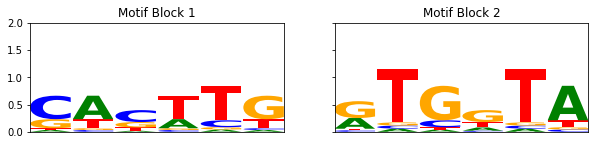

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 4% consensus


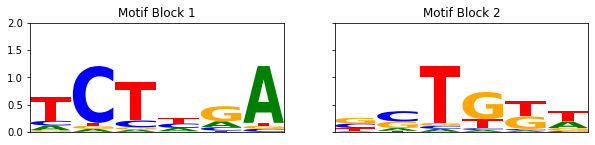

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 5% consensus


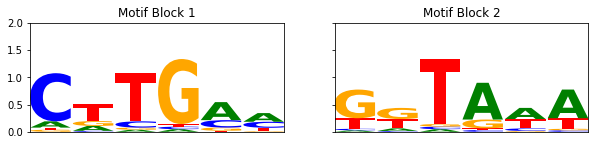

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 6% consensus


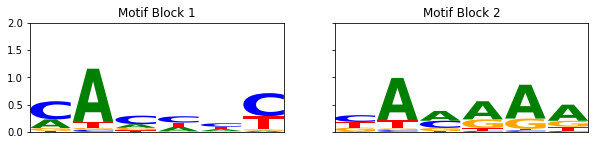

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 7% consensus


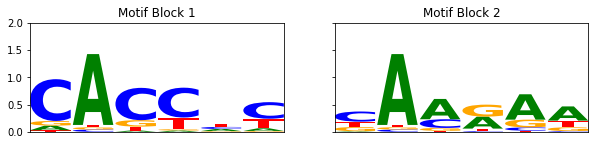

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 8% consensus


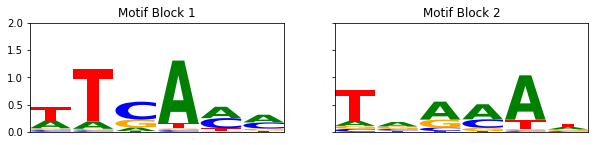

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 9% consensus


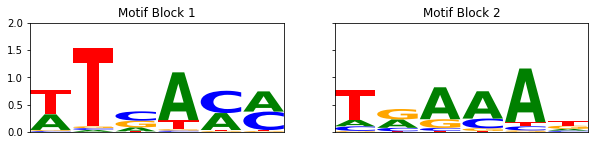

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts

Top 10% consensus


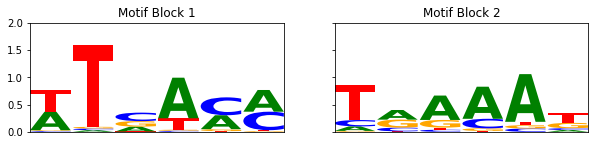

Adding categories to pssm matches...
Normalizing pssm match counts
Calculating for top scoring matches (threshold=12)
Normalizing pssm match counts
Concatting final dfs


In [26]:
# NEWORG_f_dict = {
#     3:'path/to/top3_SELECTION.fa',
#     4:'path/to/top4_SELECTION.fa',
#     ...
# }
# # Genbank file
# NEWORG_gb = "path/to/genbank_file.gb"


# NEWORG_motif_dict, \
# NEWORG_all_hex_df, \
# NEWORG_all_motif_match_df, \
# NEWORG_all_motif_match_cat_df, \
# NEWORG_all_top_motif_match_cat_df = cu.compare_consensus_motifs(NEWORG_f_dict,NEWORG_gb)


tm_f_dict = {
    3:'../tmari_out/loci_in_top_3perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616650987_SELECTION.fa',
    4:'../tmari_out/loci_in_top_4perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616650860_SELECTION.fa',
    5:'../tmari_out/loci_in_top_5perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616650836_SELECTION.fa',
    6:'../tmari_out/loci_in_top_6perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616650811_SELECTION.fa',
    7:'../tmari_out/loci_in_top_7perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616650784_SELECTION.fa',
    8:'../tmari_out/loci_in_top_8perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616650751_SELECTION.fa',
    9:'../tmari_out/loci_in_top_9perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616650715_SELECTION.fa',
    10:'../tmari_out/loci_in_top_10perc_upstream_regions_w300_minus15_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1616650674_SELECTION.fa'
    
}

# Genbank file
tm_gb = "../data/tmaritima3.gb"

tm_motif_dict, \
tm_all_hex_df, \
tm_all_motif_match_df, \
tm_all_motif_match_cat_df, \
tm_all_top_motif_match_cat_df = cu.compare_consensus_motifs(tm_f_dict,tm_gb,threshold=12)

In [ ]:
# NEWORG_enrich_df = cu.build_enrich_ratio_df(NEWORG_all_motif_match_cat_df, NEWORG_motif_dict)

# extra_org_dict = {
#     'M. buryatense': mb_enrich_df,
#     'E. coli': ec_enrich_df,
#     'B. subtilis':bs_enrich_df,
#     'NEW ORG NAME':NEWORG_enrich_df
# }

# cu.compare_orgs_chart(extra_org_dict)

In [27]:
tm_enrich_df = cu.build_enrich_ratio_df(tm_all_motif_match_cat_df, tm_motif_dict)

extra_org_dict = {
    'M. buryatense': mb_enrich_df,
    'E. coli': ec_enrich_df,
    'B. subtilis':bs_enrich_df,
    'T. maritima':tm_enrich_df
}

cu.compare_orgs_chart(extra_org_dict)

alt.LayerChart(...)

In [ ]:
# NEWORG_top_enrich_df = cu.build_enrich_ratio_df(NEWORG_all_top_motif_match_cat_df, NEWORG_motif_dict)

# extra_top_org_dict = {
#     'M. buryatense': mb_top_enrich_df,
#     'E. coli': ec_top_enrich_df,
#     'B. subtilis':bs_top_enrich_df,
#     'NEW ORG NAME':NEWORG_top_enrich_df
# }
# cu.compare_orgs_chart(extra_top_org_dict)

In [28]:
tm_top_enrich_df = cu.build_enrich_ratio_df(tm_all_top_motif_match_cat_df, tm_motif_dict)

extra_top_org_dict = {
    'M. buryatense': mb_top_enrich_df,
    'E. coli': ec_top_enrich_df,
    'B. subtilis':bs_top_enrich_df,
    'T. maritima':tm_top_enrich_df
}
cu.compare_orgs_chart(extra_top_org_dict)

alt.LayerChart(...)